# BBPSSW Protocol 

In [23]:
#imports
from qutip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, cnot
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from qutip.qip.operations.gates import (rx, ry, rz)
import random
from qutip.measurement import measure


In [3]:
#CALCULATE THETA VALUE FOR GIVEN FIDELITY
def F_to_theta(F):
    """Returns the angle theta corresponding to an input fidelity F.
    
    Keyword arguments:
    F -- fidelity between 0 and 1
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        theta = np.arcsin(2*F - 1)
    
    return theta

F_to_theta(0.6)

0.20135792079033074

In [4]:
#CUSTOM CONTROLLED ROTATION X/Y/Z GATES

def controlled_rx(arg_value):
     # controlled rotation X
     mat = np.zeros((4, 4), dtype=np.complex128)
     mat[0, 0] = mat[1, 1] = 1.
     mat[2:4, 2:4] = rx(arg_value).full()
     return Qobj(mat, dims=[[2, 2], [2, 2]])

def controlled_ry(arg_value):
     # controlled rotation Y
     mat = np.zeros((4, 4), dtype=np.complex128)
     mat[0, 0] = mat[1, 1] = 1.
     mat[2:4, 2:4] = ry(arg_value).full()
     return Qobj(mat, dims=[[2, 2], [2, 2]])

def controlled_rz(arg_value):
     # controlled rotation Z
     mat = np.zeros((4, 4), dtype=np.complex128)
     mat[0, 0] = mat[1, 1] = 1.
     mat[2:4, 2:4] = rz(arg_value).full()
     return Qobj(mat, dims=[[2, 2], [2, 2]])



In [5]:
#FUNCTION TO CHECK IF A STATE IS A WERNER STATE

def check_werner_r1(rho, tol=1e-6):
    """
    Check whether a 4x4 matrix rho corresponds to the Werner-type state:
    rho_W = r1 * |1><1| + (1-r1)/3 * (I4 - |1><1|)
    where |1> = (|01> - |10>)/sqrt(2).
    In the computational basis {|00>, |01>, |10>, |11>}, the matrix form is:
    rho_W = [[(1-r1)/3, 0, 0, 0],
    [0, (2*r1+1)/6, (1-4*r1)/6, 0],
    [0, (1-4*r1)/6, (2*r1+1)/6, 0],
    [0, 0, 0, (1-r1)/3]]
    Parameters
    ----------
    rho : 2D numpy array (shape (4,4))
    The density matrix to test.
    tol : float
    Numerical tolerance for consistency checks.
    Returns
    -------
    (is_werner, r1_value)
    is_werner : bool
    True if all derived r1 values match within 'tol'.
    r1_value : float or None
    The average r1 if consistent, else None.
    """

    # Corner diagonals (should be (1-r1)/3):

    corner_val = rho[0, 0] # same as rho[3,3] ideally

    # Center diagonals (should be (2*r1 + 1)/6):

    center_diag_val = rho[1, 1] # same as rho[2,2] ideally

    # Off-diagonals in the center block (should be (1 - 4*r1)/6):

    center_offdiag_val = rho[1, 2] # same as rho[2,1] ideally

    # Solve for r1 from each expression:

    # 1) corner_val = (1 - r1)/3 => r1 = 1 - 3 * corner_val

    r1_corner = 1.0 - 3.0 * corner_val

    # 2) center_diag_val = (2*r1 + 1)/6 => 2*r1 + 1 = 6*center_diag_val => r1 = 3*center_diag_val - 0.5

    r1_center_diag = 3.0 * center_diag_val - 0.5

    # 3) center_offdiag_val = (1 - 4*r1)/6 => 1 - 4*r1 = 6*center_offdiag_val => r1 = (1 - 6*center_offdiag_val)/4

    r1_center_offdiag = (1.0 - 6.0 * center_offdiag_val) / 4.0

    # Put them all in a list

    r1_candidates = [r1_corner, r1_center_diag, r1_center_offdiag]

    # Check if they are all close within 'tol'
    if (np.allclose(r1_corner, r1_center_diag, atol=tol) and np.allclose(r1_corner, r1_center_offdiag, atol=tol)):

        # If consistent, return average

        r1_mean = np.mean(r1_candidates)
        return True, r1_mean
    else:
    # Not consistent -> not a Werner state of this specific form
        return False, None



In [21]:

phi_plus = bell_state("00")
phi_minus = bell_state("01")
psi_plus = bell_state("10")
psi_minus = bell_state("11")

def Werner_state(F):
    """Returns Werner state of fidelity F.
    
    Keyword arguments:
    F -- fidelity of Werner state, range [0, 1]
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    
    state = F * psi_minus * psi_minus.dag() + (1 - F) / 3 * (phi_plus * phi_plus.dag() + phi_minus * phi_minus.dag() + psi_plus * psi_plus.dag())    
    return state


werner_state = Werner_state(0.6)
print(werner_state)
print(check_werner_r1(werner_state))
fidelity(werner_state, bell_state('11'))



Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.13333333  0.          0.          0.        ]
 [ 0.          0.36666667 -0.23333333  0.        ]
 [ 0.         -0.23333333  0.36666667  0.        ]
 [ 0.          0.          0.          0.13333333]]
(True, (0.6+0j))


0.7745966692414836

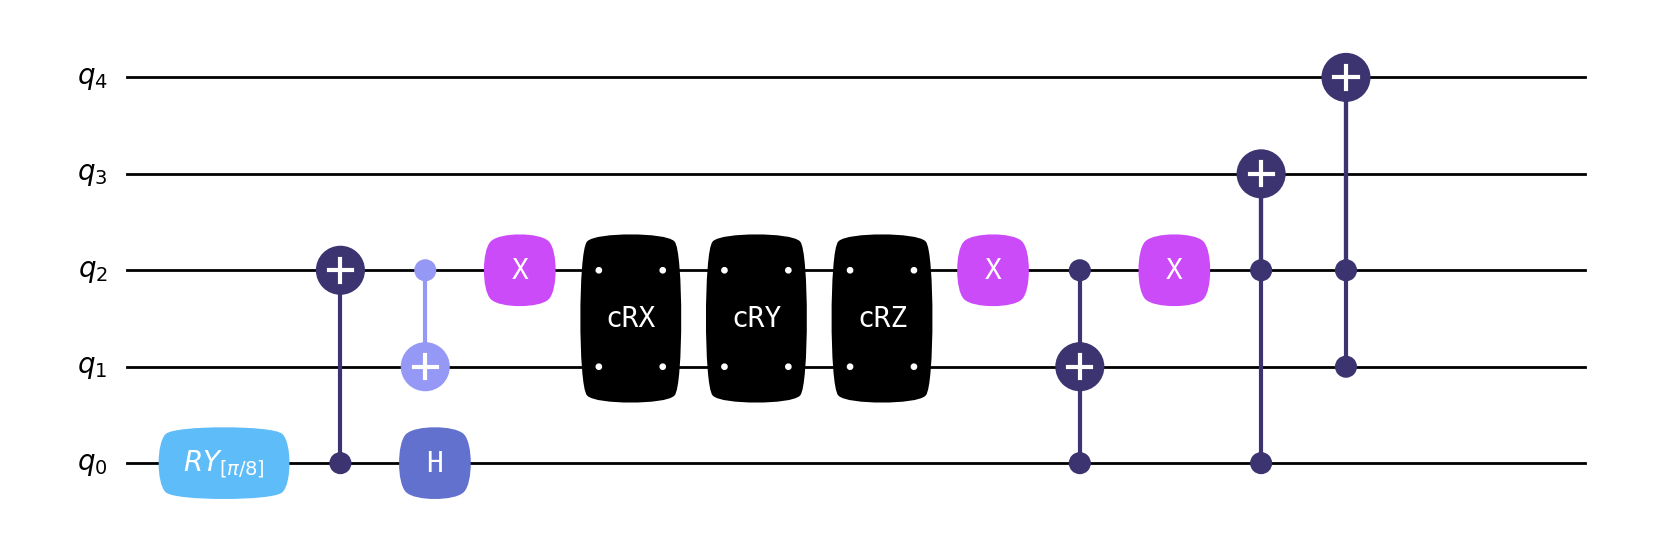

In [ ]:
# #CIRCUIT GENERATING WERNER CIRCUIT

# werner_circuit = QubitCircuit(N=5)
# werner_circuit.user_gates = {"cRX": controlled_rx, "cRY": controlled_ry, "cRZ": controlled_rz}

# werner_circuit.add_gate("RY", targets=[0], arg_value= (pi/8), style={"showarg": True})
# werner_circuit.add_gate("CNOT", controls=[0], targets=[2])
# werner_circuit.add_gate("H", targets=[0])
# werner_circuit.add_gate("CX", controls=[2], targets=[1])
# werner_circuit.add_gate("X", targets=[2])
# werner_circuit.add_gate("cRX", targets=[2,1], arg_value=pi/2)
# werner_circuit.add_gate("cRY", targets=[2,1], arg_value=pi/2)
# werner_circuit.add_gate("cRZ", targets=[2,1], arg_value=pi/2)
# # werner_circuit.add_gate("X", targets=[2])
# werner_circuit.add_gate("TOFFOLI", controls=[2,0], targets=[1])
# werner_circuit.add_gate("X", targets=[2])
# werner_circuit.add_gate("TOFFOLI", controls=[0,2], targets=[3])
# werner_circuit.add_gate("TOFFOLI", controls=[1,2], targets=[4])

# werner_circuit.draw("matplotlib", dpi=200)

In [ ]:
# #RUN WERNER CIRCUIT
# from qutip import tensor, basis
# initial_state =  tensor(basis(2,0), basis(2,0), basis(2,0), basis(2,0), basis(2,0))
# werner_result = werner_circuit.run(state=initial_state )

# # print(result)
# werner_state = werner_result.ptrace([0,1])
# # werner_state_copy = werner_state.copy()
# print(werner_state)
# print(check_werner_r1(werner_state))
# print(bell_state("11"))
# print("fidelity:", fidelity(werner_state, bell_state("00")))

In [13]:
def bilateral_rotation(circuit, qubits, rot_idx):
    """Adds a bilateral rotation to a quantum circuit.
    
    Keyword arguments:
    circuit --  quantum circuit to which the rotations are added
    qubits -- alist of qubits, each of which is rotated
    rot_idx -- integer that numbers the rotations from the set of all rotations, ranges from 0 to 11
    """
    for qubit_number in qubits:
        if rot_idx == 0:
            pass
        
        elif rot_idx == 1:
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 2:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 3:
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 4:
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 5:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 6:
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 7:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 8:
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 9:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 10:
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 11:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        else:
            raise Exception('Input argument rot_idx has to be an integer between 0 and 11.')

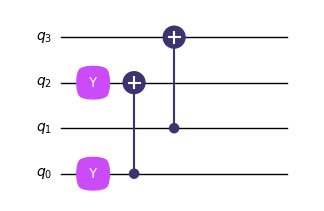

In [ ]:
purification_circuit= QubitCircuit(N=4)
purification_circuit.add_gate("Y", targets=[0])
purification_circuit.add_gate("Y", targets=[2])
purification_circuit.add_gate("CNOT", targets = [2], controls=[0])
purification_circuit.add_gate("CNOT", targets = [3], controls=[1])

purification_circuit.draw("matplotlib", dpi=100)

purification_result = purification_circuit.run(state = tensor(werner_state, werner_state))
Z0, Z1 = ket2dm(basis(2, 0)), ket2dm(basis(2, 1))
PZ1 = [tensor(identity(2), identity(2), Z0, Z0), tensor(identity(2), identity(2), Z1, Z1), tensor(identity(2), identity(2), Z0, Z1), tensor(identity(2), identity(2), Z1, Z0)]
measurement_result = measure(purification_result,PZ1)

if measurement_result[0] == 0 or measurement_result[0] == 1:
    print("succesful purification result")

    post_purification_state = purification_result.ptrace([0,1])
    print("Post Purification State: ",post_purification_state)

    post_purification = QubitCircuit(N=2)
    post_purification.add_gate("Y", targets=[1])
    rand_int = np.random.randint(12)
    bilateral_rotation(post_purification, [0,1], rand_int)

    post_purif_result = post_purification.run(state = post_purification_state)
    print("Post Result: ",post_purif_result)
    print(fidelity(post_purif_result,bell_state("11")))

    post_purification.draw("matplotlib", dpi = 200)
